In [1]:
!pip install --upgrade gensim

Requirement already up-to-date: gensim in /Applications/anaconda3/lib/python3.6/site-packages (3.8.1)


In [2]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

from Processing import Processor

In [3]:
nlp = spacy.load("en_core_web_lg")
processor = Processor(nlp = nlp)

In [6]:
path = 'txt_files/'

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.txt' in file:
            files.append(os.path.join(r, file))
            
files[:10]

In [7]:
corpus = {}            
for f in files:
    contents = processor.bytes_to_string(f)
    corpus[f[len(path):-4]] = contents

In [8]:
df = pd.DataFrame({'file': list(corpus.keys()), 'text': list(corpus.values())})

In [9]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

spacy_stopwords.add('\n')
spacy_stopwords.add(':')
spacy_stopwords.add('')
spacy_stopwords.add('object')
spacy_stopwords.add('observe')
spacy_stopwords.add('space')
spacy_stopwords.add('orbit')

In [10]:
import re

def tokenize(text):
    
    text = text.lower()
    text = re.sub(r'[^a-zA-Z ^0-9]', ' ', str(text))
    doc = nlp.tokenizer(text)
    
    lemmas = [token.lemma_ + ' ' for token in doc]
    
    cleaned = []
    for token in lemmas:
        if token not in spacy_stopwords:
            cleaned.append(token)
            
    return ''.join(cleaned)

df['tokens'] = df['text'].apply(lambda x:tokenize(x))

df['tokens'].head()

0    see discussion   stats   and author profile fo...
1    astronomical engineer   a strategy for modify ...
2    icarus 158   146 177   2002   doi 10 1006 icar...
3    space resource roundtable ii   2000    7030 pd...
4    csr in space   corporate social responsibility...
Name: tokens, dtype: object

In [16]:
df.head()

,file,text,tokens
0,Navigation to Small Bodies,"See discussions, stats, and author profiles fo...",see discussion stats and author profile fo...
1,ASTRONOMICAL ENGINEERING,ASTRONOMICAL ENGINEERING: A STRATEGY FOR MODIF...,astronomical engineer a strategy for modify ...
2,Phase II of the Main Belt Asteroid Spectrosopi...,"Icarus 158, 146�177 (2002) doi:10.1006/icar.20...",icarus 158 146 177 2002 doi 10 1006 icar...
3,Mine planning for Asteroid Ore Bodies,Space Resources Roundtable II (2000)\n\n7030.p...,space resource roundtable ii 2000 7030 pd...
4,CSR in space,CSR in Space: Corporate Social Responsibility ...,csr in space corporate social responsibility...


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
dtm = tfidf.fit_transform(df['tokens'].tolist())

docs = pd.DataFrame(dtm.todense(), columns = tfidf.get_feature_names())
docs.head()

,00,000,0000,001,002,003,004,005,006,007,...,z0,zellner,zenith,zeolite,zero,zeus,zhang,zolensky,zone,zoom
0,0.000000,0.014790,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.005887,0.000000,0.0,0.0,0.002902,0.0,0.0,0.0,0.000000,0.006259
1,0.000000,0.003600,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.008477,0.0,0.0,0.0,0.002962,0.000000
2,0.001532,0.000601,0.009158,0.00324,0.005196,0.002598,0.001245,0.005577,0.009859,0.007178,...,0.000000,0.019062,0.0,0.0,0.001415,0.0,0.0,0.0,0.004947,0.000000
3,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,0.000000,0.003426,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000672,0.0,0.0,0.0,0.000940,0.000000


In [12]:
dtm.todense().T

matrix([[0.        , 0.        , 0.00153167, ..., 0.02255341, 0.        ,
         0.        ],
        [0.01479033, 0.00360005, 0.00060111, ..., 0.        , 0.01743875,
         0.00554982],
        [0.        , 0.        , 0.00915778, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.00395004,
         0.        ],
        [0.        , 0.00296248, 0.00494653, ..., 0.        , 0.        ,
         0.        ],
        [0.00625911, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

# Processing for Topic Model

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['tokens'].tolist()))

print(df['tokens'].tolist()[:1])

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

In [19]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in spacy_stopwords] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

In [54]:
from gensim.models import LsiModel

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [55]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.025*"space" + 0.020*"material" + 0.019*"lunar" + 0.013*"use" + 0.012*"construction" + 0.010*"structure" + 0.009*"moon" + 0.009*"concrete" + 0.008*"process" + 0.007*"design"'), (1, '0.001*"space" + 0.001*"system" + 0.001*"use" + 0.001*"asteroid" + 0.001*"mission" + 0.000*"earth" + 0.000*"time" + 0.000*"orbit" + 0.000*"require" + 0.000*"launch"'), (2, '0.048*"binary" + 0.025*"disk" + 0.011*"orbit" + 0.010*"time" + 0.010*"mass" + 0.009*"average" + 0.009*"accretion" + 0.009*"leave" + 0.008*"orbital" + 0.008*"right"'), (3, '0.025*"space" + 0.010*"system" + 0.008*"mission" + 0.007*"earth" + 0.007*"mar" + 0.007*"use" + 0.006*"human" + 0.006*"lunar" + 0.006*"design" + 0.006*"vehicle"'), (4, '0.030*"asteroid" + 0.015*"spectrum" + 0.013*"spectral" + 0.012*"band" + 0.011*"pyroxene" + 0.010*"meteorite" + 0.008*"composition" + 0.008*"type" + 0.008*"olivine" + 0.007*"icarus"'), (5, '0.002*"asteroid" + 0.002*"type" + 0.002*"earth" + 0.001*"use" + 0.001*"space" + 0.001*"trajectory" + 0.001*"or

In [56]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.701162886066127

Coherence Score:  0.5024636166743081


In [57]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.073257 -0.122847       1        1  32.568600
12     0.179522 -0.082031       2        1  14.935785
17     0.105539  0.037577       3        1  13.598143
18     0.112882  0.090266       4        1   8.272854
11     0.094702 -0.119850       5        1   6.702238
13     0.117673  0.220305       6        1   4.462396
2      0.077383  0.032587       7        1   3.427659
0      0.046122 -0.110213       8        1   3.097469
4      0.064934  0.195938       9        1   2.806055
16     0.007553 -0.114453      10        1   2.071100
8      0.064064 -0.032048      11        1   1.972006
6     -0.021524 -0.001076      12        1   1.927956
7      0.055874 -0.011486      13        1   1.925413
19     0.041719  0.009313      14        1   1.403928
9     -0.060428 -0.076739      15        1   0.807182
15    -0.220889  0.017854      16        1   0.019689
5     -0.172520  0.031319      17        1   0.000396
14    -0.157481 -0.002239      18        1   0.000382
10    -0.191781  0.021453      19        1   0.000377
1     -0.216597  0.016371      20        1   0.000372, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
53    Default  3281.000000        asteroid  3281.000000  30.0000  30.0000
820   Default  4045.000000           space  4045.000000  29.0000  29.0000
603   Default  1907.000000           orbit  1907.000000  28.0000  28.0000
909   Default  1245.000000      trajectory  1245.000000  27.0000  27.0000
1193  Default   667.000000  gravity_assist   667.000000  26.0000  26.0000
537   Default  2024.000000         mission  2024.000000  25.0000  25.0000
323   Default   799.000000           flyby   799.000000  24.0000  24.0000
929   Default  2393.000000             use  2393.000000  23.0000  23.0000
1031  Default   563.000000          binary   563.000000  22.0000  22.0000
875   Default  2094.000000          system  2094.000000  21.0000  21.0000
492   Default  1110.000000           lunar  1110.000000  20.0000  20.0000
236   Default  2402.000000           earth  2402.000000  19.0000  19.0000
3059  Default  1115.000000            type  1115.000000  18.0000  18.0000
504   Default   566.000000        maneuver   566.000000  17.0000  17.0000
659   Default  1019.000000           power  1019.000000  16.0000  16.0000
817   Default   715.000000        solution   715.000000  15.0000  15.0000
1282  Default   867.000000        material   867.000000  14.0000  14.0000
1293  Default   663.000000          method   663.000000  13.0000  13.0000
899   Default  1219.000000            time  1219.000000  12.0000  12.0000
5505  Default   438.000000        periapse   438.000000  11.0000  11.0000
511   Default   908.000000            mass   908.000000  10.0000  10.0000
821   Default   909.000000      spacecraft   909.000000   9.0000   9.0000
1512  Default   716.000000        transfer   716.000000   8.0000   8.0000
50    Default   558.000000        assembly   558.000000   7.0000   7.0000
764   Default   652.000000       satellite   652.000000   6.0000   6.0000
507   Default   929.000000             mar   929.000000   5.0000   5.0000
886   Default   799.000000      technology   799.000000   4.0000   4.0000
208   Default  1091.000000          design  1091.000000   3.0000   3.0000
1169  Default   735.000000          figure   735.000000   2.0000   2.0000
5051  Default   318.000000            disk   318.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
537   Topic20     0.000610         mission  2024.347168  -2.5139  -7.5872
53    Topic20     0.000624        asteroid  3281.150879  -2.9742  -7.5645
236   Topic20     0.000545           earth  2402.228027  -2.7974  -7.6996
71    Topic20     0.000374            base   803.710693  -2.0801  -8.0772
899   Topic20     0.000415     

# Mallet Topic Alogrithm 

In [27]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [28]:
# Show Topics
print(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCohereldamalletnce Score: ', coherence_ldamallet)

[(12, [('earth', 0.04096844108473859), ('orbit', 0.03377914045567479), ('object', 0.02325950203520643), ('time', 0.014801501295131364), ('encounter', 0.01437860125812761), ('orbital', 0.013638526193371041), ('neo', 0.012264101073108843), ('energy', 0.01184120103610509), ('velocity', 0.010783950943595707), ('year', 0.010466775915842892)]), (18, [('asteroid', 0.060209424083769635), ('method', 0.028795811518324606), ('burn', 0.022142233856893543), ('delta', 0.019851657940663178), ('mission', 0.0162521815008726), ('low', 0.015052356020942409), ('mass', 0.013852530541012216), ('table', 0.011780104712041885), ('fig', 0.010471204188481676), ('resource', 0.010143979057591623)]), (13, [('binary', 0.060284732449680904), ('disk', 0.03377515954835542), ('mass', 0.013942071674030438), ('time', 0.01207658321060383), ('average', 0.01207658321060383), ('leave', 0.011880216003927344), ('orbit', 0.01168384879725086), ('orbital', 0.011094747177221405), ('accretion', 0.010898379970544918), ('eccentricity'

# Finding Optimal Topic Numbers 

In [47]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [48]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

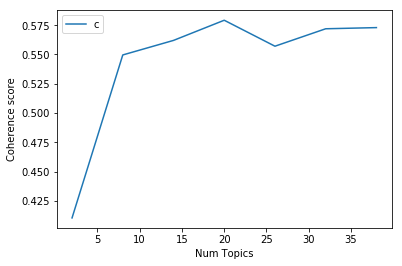

In [49]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [50]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4105
Num Topics = 8  has Coherence Value of 0.5496
Num Topics = 14  has Coherence Value of 0.562
Num Topics = 20  has Coherence Value of 0.5792
Num Topics = 26  has Coherence Value of 0.557
Num Topics = 32  has Coherence Value of 0.5719
Num Topics = 38  has Coherence Value of 0.5729


In [51]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(0, '0.033*"space" + 0.018*"system" + 0.015*"technology" + 0.014*"station" + 0.014*"program" + 0.013*"test" + 0.013*"control" + 0.011*"design" + 0.011*"material" + 0.010*"power"'), (1, '0.033*"mar" + 0.025*"lunar" + 0.020*"vehicle" + 0.019*"mission" + 0.019*"system" + 0.019*"human" + 0.018*"earth" + 0.016*"space" + 0.012*"moon" + 0.012*"provide"'), (2, '0.039*"satellite" + 0.024*"orbit" + 0.021*"small" + 0.020*"mission" + 0.017*"constellation" + 0.017*"launch" + 0.015*"cubesat" + 0.015*"system" + 0.014*"deployment" + 0.012*"spacecraft"'), (3, '0.021*"space" + 0.012*"suit" + 0.011*"design" + 0.010*"system" + 0.009*"concept" + 0.009*"module" + 0.008*"radiation" + 0.007*"gravity" + 0.007*"crow" + 0.007*"mission"'), (4, '0.094*"space" + 0.013*"resource" + 0.013*"international" + 0.013*"industry" + 0.011*"law" + 0.011*"state" + 0.010*"outer" + 0.010*"earth" + 0.009*"asteroid" + 0.009*"activity"'), (5, '0.052*"asteroid" + 0.017*"earth" + 0.013*"small" + 0.013*"nea" + 0.012*"water" + 0.011*"

# Finding the Dominant Topic in Each Document 

In [53]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['tokens'].tolist()):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df['tokens'].tolist())

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic['doc_name'] = df['file']
# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,doc_name
0,0,19.0,0.4330,"object, datum, asteroid, observation, telescop...",see discussion stats and author profile fo...,Navigation to Small Bodies
1,1,11.0,0.6311,"earth, orbit, asteroid, encounter, object, ene...",astronomical engineer a strategy for modify ...,ASTRONOMICAL ENGINEERING
2,2,18.0,0.8088,"asteroid, type, class, spectrum, spectral, com...",icarus 158 146 177 2002 doi 10 1006 icar...,Phase II of the Main Belt Asteroid Spectrosopi...
3,3,7.0,0.3129,"space, design, activity, base, earth, project,...",space resource roundtable ii 2000 7030 pd...,Mine planning for Asteroid Ore Bodies
4,4,4.0,0.7198,"space, resource, international, industry, law,...",csr in space corporate social responsibility...,CSR in space
5,5,13.0,0.8284,"trajectory, flyby, gravity_assist, solution, m...",copyright by martin james brennan 2015 the ...,Interplanetary Trajectory
6,6,2.0,0.4184,"satellite, orbit, small, mission, constellatio...",available online at www sciencedirect com scie...,SmallSat Constelation
7,7,10.0,0.2488,"material, lunar, space, structure, constructio...",journal of the british interplanetary society ...,Directed Passpermia
8,8,2.0,0.2113,"satellite, orbit, small, mission, constellatio...",see discussion stats and author profile fo...,The Rise of Interplanetary Cubesats
9,9,2.0,0.8490,"satellite, orbit, small, mission, constellatio...",acta astronautica 114 2015 65 78 content l...,Launch and Deployment of Distributted Small Sa...


In [64]:
pd.set_option('display.max_colwidth', -1)

df_dominant_topic['Keywords'][:10]

0    object, datum, asteroid, observation, telescope, target, neo, image, observe, discovery         
1    earth, orbit, asteroid, encounter, object, energy, burn, orbital, velocity, transfer            
2    asteroid, type, class, spectrum, spectral, complex, object, albedo, feature, taxonomy           
3    space, design, activity, base, earth, project, architecture, lunar, vertical, launch            
4    space, resource, international, industry, law, state, outer, earth, asteroid, activity          
5    trajectory, flyby, gravity_assist, solution, maneuver, mission, power, periapse, optimal, orbit 
6    satellite, orbit, small, mission, constellation, launch, cubesat, system, deployment, spacecraft
7    material, lunar, space, structure, construction, habitat, melt, moon, regolith, sinter          
8    satellite, orbit, small, mission, constellation, launch, cubesat, system, deployment, spacecraft
9    satellite, orbit, small, mission, constellation, launch, cubesat, system, dep